In [44]:
"""
This notebook contains code for drawing face-detected and random samples from a video, 
annotating on face/no face, calculating precision, recall, and F-score, 
and visualizing the scores across detectors, groups, and videos.
"""
%load_ext autoreload
%autoreload 2

import os
import sys
import subprocess
import ntpath

from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import collections  as mc

print('Importing FaceDetector...')
from config import *
from detector import FaceDetector
from utils import (format_num, create_sample_json, annotate_sample, 
                   run_detector_on_sample, incorporate_openpose_output, 
                   calc_prf, display_prf, display_prf2, submit_sbatch, run_openpose, viz_prf, print_prf)

print(sys.path) #should somewhere include [...]/miniconda2/envs/headcam/[...]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Importing FaceDetector...
['/home/users/agrawalk/miniconda2/envs/headcam/lib/python36.zip', '/home/users/agrawalk/miniconda2/envs/headcam/lib/python3.6', '/home/users/agrawalk/miniconda2/envs/headcam/lib/python3.6/lib-dynload', '', '/home/users/agrawalk/.local/lib/python3.6/site-packages', '/home/users/agrawalk/miniconda2/envs/headcam/lib/python3.6/site-packages', '/home/users/agrawalk/miniconda2/envs/headcam/lib/python3.6/site-packages/IPython/extensions', '/home/users/agrawalk/.ipython']


In [17]:
#1. Extract frames from video

for vid_path in ['NEW_VID_PATHS']:
    msg = submit_sbatch(f'python extract_frames.py {vid_path}', job_name='extract', p='normal,hns', t=2)
    print(msg)

(b'Submitted batch job 44773571\n', b'')


In [26]:
#Confirm jobs are submitted
!squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          44971496       gpu demovide agrawalk PD       0:00      1 (Priority)
          44956279       hns  jupyter agrawalk  R    4:45:05      1 sh-108-15


In [ ]:
#2. Run MTCNN on 10000 frames of each video
#TODO: add case to check if output json exists, and ask for confirmation to overwrite

for frame_dir in FRAME_DIRS:
    msg = submit_sbatch(f'python detect_faces_simple.py {vid_path} {MASTER_JSON_PATH}', 
                        job_name='extract', p='normal,hns', c=8, t=2)
    print(msg)

In [ ]:
#3. select a random sample of [sample_size] face-detected, [sample_size] random frames from each video in the dataframe
#e.g. if 6 videos in JSON and sample_size=200, creates a sample dataframe of size (200 + 200)*6 = 2400 frames
#TODO: add case to check if output json exists, and ask for confirmation to overwrite

create_sample_json(MASTER_JSON_PATH, SAMPLE_JSON_PATH, sample_size=200)

In [ ]:
#4a. run + add detections for additional detectors to sample dataframe.

for det_name in ['vj']:
    run_detector_on_sample(det_name, OUTPUT, SAMPLE_JSON_PATH)

In [58]:
test_vid = '/scratch/users/agrawalk/testvideos/061713-1.AVI'

run_openpose(test_vid, SCRATCH, no_display=True,
             render_pose=0, keypoint_scale=3, 
             frame_rotate=180, face=True, hand=False)

run_openpose(test_vid, SCRATCH, no_display=True,
             render_pose=0, keypoint_scale=3, 
             frame_rotate=180, face=True, hand=True)

In [25]:
!squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          44971496       gpu demovide agrawalk PD       0:00      1 (Priority)
          44956279       hns  jupyter agrawalk  R    4:42:41      1 sh-108-15


In [ ]:
#4b. Run openpose on videos

for vid_path in NEW_VID_PATHS:
    msg = run_openpose(vid_path, OPENPOSE_OUTPUT, no_display=True, 
                       render_pose=0, keypoint_scale=3, 
                       frame_rotate=180, face=True, hand=True)
    print(msg)

In [ ]:
#5b. add openpose data to the dataframe.
#TODO: add case to check if openpose column exists, and ask for confirmation to overwrite
#TODO: in this function, create the calculated columns 'face_openpose' and 'face_openpose_body'
incorporate_openpose_output(SAMPLE_JSON_PATH, OPENPOSE_OUTPUT)

In [ ]:
#4c. Hand-annotate for face (y/n) on the sample. Save annotations to dataframe.
#TODO: add case to check if annotation column exists, and ask for confirmation to overwrite

annotate_frames(OUTPUT, SAMPLE_JSON_PATH)

In [ ]:
display_prf(SAMPLE_JSON_PATH)

In [ ]:
display_prf2(SAMPLE_JSON_PATH)

In [2]:
#6. Visualize detector scores

df = pd.read_json('gold_set_sample.json')
df.head()

,vid_name,frame,face_mtcnn,bb_mtcnn,bb_vj,face_vj,pose_keypoints,face_keypoints,hand_left_keypoints,hand_right_keypoints,face_present,face_openpose,face_openpose_body,bb_pcn,face_pcn,random
0,053113-1,3878,False,[],[],False,[],[],[],[],0,False,False,[],False,True
1,053113-1,36428,False,[],[],False,[],[],[],[],0,False,False,[],False,True
10,053113-1,16215,True,"[[321, 31, 140, 205], [118, 154, 120, 139]]",[],False,"[[163.05, 230.85, 0.784454, 153.926, 294.783, ...","[[91.6659, 162.313, 0.000147011, 91.6659, 162....","[[312.67, 329.055, 0.0206327, 318.735, 319.779...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,True,True,[],False,True
100,053113-1,21908,False,[],[],False,[],[],[],[],0,False,False,[],False,True
1000,2014-06-18-part2,16908,False,[],[],False,[],[],[],[],0,False,False,[],False,True


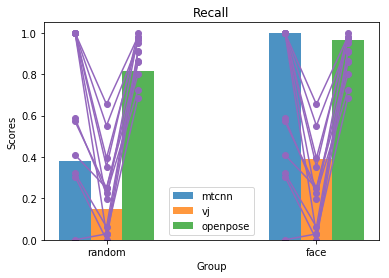

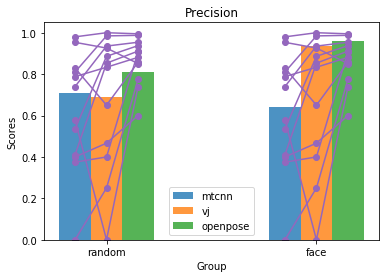

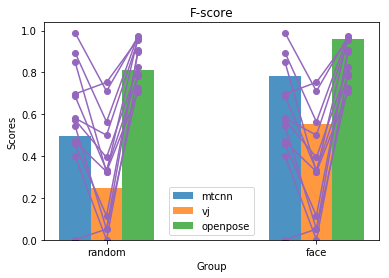

In [3]:
viz_prf(df)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#TODO: start using the below:
#from sklearn.metrics import classification_report
#print(classification_report(y_test,predictions))

In [6]:
X = df.filter(items=[f'face_{det}' for det in ['openpose', 'vj', 'mtcnn']])
Y = df['face_present']
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.30, random_state=101)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

/home/users/agrawalk/miniconda2/envs/headcam/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       388
           1       0.91      0.92      0.92       332

   micro avg       0.92      0.92      0.92       720
   macro avg       0.92      0.92      0.92       720
weighted avg       0.92      0.92      0.92       720



In [23]:
def nose_confidence(row):
    if len(row['face_keypoints']) == 0:
        return -1
    #Nose is keypoint 30, 30*3 = 90 , 90 + 2 = 92 (add 2, because confidence is after (x,y))
    return np.average(np.array(row['face_keypoints'])[:, 30*3 + 2])

def median_confidence(row):
    if len(row['face_keypoints']) == 0:
        return -1
    return np.median(np.array(row['face_keypoints'])[:, 2::3])

df['nose_confidence'] = df.apply(nose_confidence, axis=1)
df['median_confidence'] = df.apply(median_confidence, axis=1)

In [16]:
np.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

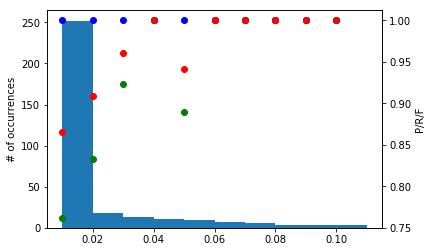

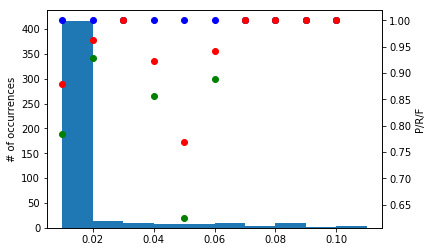

In [54]:
n_bins = 100

for conf_metric in ['median_confidence', 'nose_confidence']:
    bins = [x/n_bins for x in range(n_bins + 1)]

    ps = []
    rs = []
    fs = []
    lens = []
    for low, high in zip(bins[:-1], bins[1:]):
        cut = df[np.logical_and(df[conf_metric] > low, df[conf_metric] <= high)]
    #     print(f'bin: below {}')
        p, r, f = calc_prf(cut, 'openpose')
        ps.append(p)
        rs.append(r)
        fs.append(f)
        lens.append(len(cut))

    bins = bins[1:]
    end = 10

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax1.bar(bins[:end], lens[:end], width=0.01, align='edge')
    ax1.set_ylabel('# of occurrences')
    ax1
    
    ax2.plot(bins[:end], ps[:end], 'go') #Green = P
    ax2.plot(bins[:end], rs[:end], 'bo') #Blue = R
    ax2.plot(bins[:end], fs[:end], 'ro') #Red = F
    ax2.set_ylabel('P/R/F')
    
    plt.xlabel('Confidence')
    plt.show()
    #Seems like it's fine after 0.08? Can confirm this trend on the next gold set.

In [35]:
print([0] + bins)

[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]


In [42]:
len(df)

2400

In [43]:
for threshold in ([0] + bins)[:10]:
    cut = df[df['nose_confidence'] > threshold]
    prf = calc_prf(cut, 'openpose')
    print(len(cut))
    print(f'P, R, F for conf > {threshold}: {prf} Percent data lost: {1 - len(cut)/len(df)}')

1114
P, R, F for conf > 0: (0.9129263913824057, 1.0, 0.9544814641013608) Percent data lost: 0.5358333333333334
697
P, R, F for conf > 0.01: (0.9899569583931134, 1.0, 0.9949531362653209) Percent data lost: 0.7095833333333333
683
P, R, F for conf > 0.02: (0.9912152269399708, 1.0, 0.9955882352941177) Percent data lost: 0.7154166666666666
673
P, R, F for conf > 0.03: (0.9910846953937593, 1.0, 0.9955223880597015) Percent data lost: 0.7195833333333334
666
P, R, F for conf > 0.04: (0.9924924924924925, 1.0, 0.9962321024868124) Percent data lost: 0.7224999999999999
658
P, R, F for conf > 0.05: (0.9969604863221885, 1.0, 0.9984779299847794) Percent data lost: 0.7258333333333333
649
P, R, F for conf > 0.06: (0.9984591679506933, 1.0, 0.9992289899768697) Percent data lost: 0.7295833333333333
645
P, R, F for conf > 0.07: (0.9984496124031008, 1.0, 0.9992242048099302) Percent data lost: 0.73125
636
P, R, F for conf > 0.08: (0.9984276729559748, 1.0, 0.9992132179386309) Percent data lost: 0.735
634
P, R,

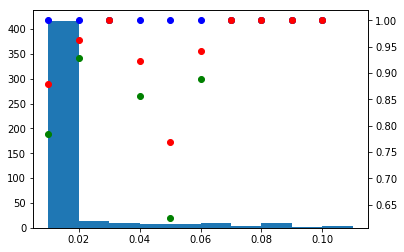

In [30]:
end = 10

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.bar(bins[:end], lens[:end], width=0.01, align='edge')

ax2.plot(bins[:end], ps[:end], 'go') #Green = P
ax2.plot(bins[:end], rs[:end], 'bo') #Blue = R
ax2.plot(bins[:end], fs[:end], 'ro') #Red = F

plt.show()

In [33]:
calc_prf(df[np.logical_and(df['nose_confidence'] >= 0.0, df['nose_confidence'] < 0.01)], 'openpose')

(0.7841726618705036, 0.8320610687022901, 0.8074074074074076)

In [38]:
df[df['nose_confidence'] == 0.0].head()

,vid_name,frame,face_mtcnn,bb_mtcnn,bb_vj,face_vj,pose_keypoints,face_keypoints,hand_left_keypoints,hand_right_keypoints,face_present,face_openpose,face_openpose_body,bb_pcn,face_pcn,random,nose_confidence
1003,2014-06-18-part2,9618,False,[],[],False,"[[359.959, 233.41, 0.677028, 362.626, 255.653,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[306.682, 312.535, 0.00873381, 306.327, 310.9...",1,False,True,[],False,True,0.0
1011,2014-06-18-part2,7596,False,[],[],False,"[[0, 0, 0, 383.476, 333.917, 0.056060000000000...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[422.592, 415.589, 0.011596799999999999, 414....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,False,True,[],False,True,0.0
1016,2014-06-18-part2,7352,False,[],[],False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,False,True,[],False,True,0.0
1020,2014-06-18-part2,8133,False,[],[],False,"[[191.671, 121.313, 0.585809, 170.921, 138.276...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[201.532, 200.148, 0.0174552, 198.035, 201.54...",0,False,True,[],False,True,0.0
1023,2014-06-18-part2,16170,True,"[[623, 309, 63, 73]]",[],False,"[[216.549, 160.418, 0.470554, 215.223, 183.926...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,False,True,[],False,True,0.0


In [41]:
len(df[df['nose_confidence'] == 0.0])

476

In [36]:
calc_prf(df[df['nose_confidence'] == 0.0], 'openpose')

(0.0, 0.0, 0.0)

In [39]:
calc_prf(df[df['nose_confidence'] == 0.0], 'openpose_body')

(0.13865546218487396, 1.0, 0.24354243542435428)

In [34]:
calc_prf(df[np.logical_and(df['nose_confidence'] > 0.0, df['nose_confidence'] < 0.01)], 'openpose')

(0.7841726618705036, 1.0, 0.8790322580645161)

In [40]:
calc_prf(df[np.logical_and(df['nose_confidence'] >= 0.0, df['nose_confidence'] < 0.01)], 'openpose')

(0.7841726618705036, 0.8320610687022901, 0.8074074074074076)

In [9]:
print(lens[:10])

[417, 14, 10, 7, 8, 9, 4, 9, 2, 4]


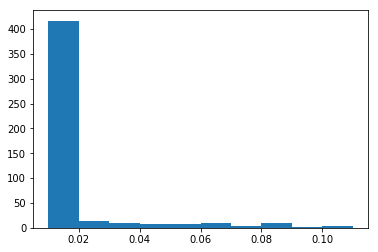

In [10]:
plt.bar(bins[:end], lens[:end], width=0.01, align='edge')
plt.show()

In [9]:
df2 = df[df['nose_confidence'] != -1]

max(df2['nose_confidence'])

0.974028

In [7]:
for confidence in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    print(f'confidence: {confidence}')
    print_prf(df[df['nose_confidence'] == confidence])

confidence: 0
Precision
openpose: [0.6919431279620853, 0.8775510204081632]
Recall
openpose: [0.7849462365591398, 0.8921161825726142]
F-score
openpose: [0.7355163727959697, 0.8847736625514404]
confidence: 0.1
Precision
openpose: [1.0, 0.9615384615384616]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 0.9803921568627451]
confidence: 0.2
Precision
openpose: [1.0, 1.0]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 1.0]
confidence: 0.3
Precision
openpose: [1.0, 1.0]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 1.0]
confidence: 0.4
Precision
openpose: [1.0, 0.9888888888888889]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 0.9944134078212291]
confidence: 0.5
Precision
openpose: [1.0, 1.0]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 1.0]
confidence: 0.6
Precision
openpose: [1.0, 1.0]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 1.0]
confidence: 0.7
Precision
openpose: [1.0, 1.0]
Recall
openpose: [1.0, 1.0]
F-score
openpose: [1.0, 1.0]
confidence: 0.8
Prec

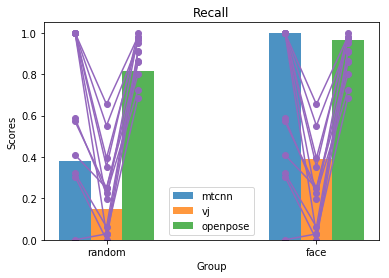

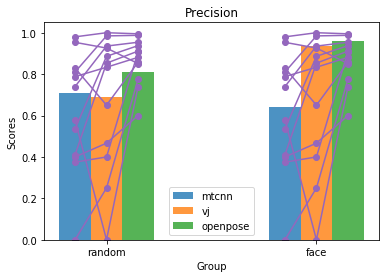

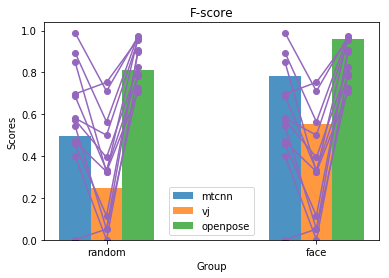

In [9]:
viz_prf(df)

In [5]:
df['random'] = df.index < 1200

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 999
Data columns (total 15 columns):
vid_name                2400 non-null object
frame                   2400 non-null int64
face_mtcnn              2400 non-null bool
bb_mtcnn                2400 non-null object
bb_vj                   2400 non-null object
face_vj                 2400 non-null bool
pose_keypoints          2400 non-null object
face_keypoints          2400 non-null object
hand_left_keypoints     2400 non-null object
hand_right_keypoints    2400 non-null object
face_present            2400 non-null int64
face_openpose           2400 non-null bool
face_openpose_body      2400 non-null bool
bb_pcn                  2400 non-null object
face_pcn                2400 non-null bool
dtypes: bool(5), int64(2), object(8)
memory usage: 218.0+ KB


In [ ]:
openpose_true = df[df['face_present'] == df['face_openpose']]
openpose_false = df[df['face_present'] != df['face_openpose']]


openpose_tp = openpose_true[openpose_true['face_openpose'] == True]
openpose_tn = openpose_true[openpose_true['face_openpose'] == False]

openpose_fp = openpose_false[openpose_false['face_openpose'] == True]
openpose_fn = openpose_false[openpose_false['face_openpose'] == False]

print(len(openpose_tp))
print(len(openpose_tn))
print(len(openpose_fp))
print(len(openpose_fn))

In [ ]:
openpose_tp[-30:]

In [ ]:
openpose_tp[-30:].apply(viz_op_keypoints, axis=1)

In [ ]:
openpose_tp[2:3]
#copy the image
#

In [ ]:
openpose_fp.head()

In [ ]:
openpose_fp[:20].apply(viz_op_keypoints, axis=1)

In [ ]:
openpose_tn[:20].apply(viz_op_keypoints, axis=1)

In [ ]:
openpose_fn[:20].apply(viz_op_keypoints, axis=1)

In [ ]:
#7. Visualize frames which Openpose succeeds (True Positive) and MTCNN fails (False Positive/False Negative).

def openpose_not_mtcnn(row):
    return row['face_present'] == row['face_openpose'] and row['face_present'] != row['face_mtcnn']

op_not_mtcnn = df[df.apply(openpose_not_mtcnn, axis=1)]

mtcnn_fp = op_not_mtcnn[op_not_mtcnn['face_present'] == False] #but MTCNN returned True
mtcnn_fn = op_not_mtcnn[op_not_mtcnn['face_present'] == True] #but MTCNN returned False

print(f'Num False positives: {len(mtcnn_fp)}')
print(f'Num False negatives: {len(mtcnn_fn)}')

In [ ]:
def openpose_succeeds(row):
    return row['face_present'] == row['face_openpose']

op_succeeds = df[df.apply(openpose_succeeds, axis=1)]

In [ ]:
img_paths = [os.path.join(OUTPUT, f'{vid_name}_frames/image-{format_num(num)}.jpg')
                 for vid_name, num in zip(mtcnn_fp['vid_name'], mtcnn_fp['frame'])]
imgs = [plt.imread(path) for path in img_paths]

for img in imgs[:3]:
    plt.imshow(img)
    plt.show()

In [ ]:
#return x and y arrays for a single frame

def get_op_xy(keypt_lists):
    x = []
    y = []
    for keypt in keypt_lists:
        x.append(keypt[0::3]) 
        y.append(keypt[1::3])
    if x == [] or y == []:
        return [], []
    
    return x[0], y[0]

def get_op_lines(x, y, pairings):
    lines = []
    print(f'length of x: {len(x)}')
    print(f'length of y: {len(y)}')

    for x1, y1 in zip(x, y):
        line = []
        for p1, p2 in pairings:
            print(p1, p2)
            line.append([(x[p1], y[p1]), (x[p2], y[p2])])
        lines.append(line)
    return lines

In [ ]:
face_pairings = [0,1,  1,2,  2,3,  3,4,  4,5,  5,6,  6,7,  7,8,  8,9,  9,10,  10,11,  11,12,  12,13,  13,14,  14,15,  15,16,  17,18,  18,19,  19,20, \
                 20,21,  22,23,  23,24,  24,25,  25,26,  27,28,  28,29,  29,30,  31,32,  32,33,  33,34,  34,35,  36,37,  37,38,  38,39,  39,40,  40,41, \
                 41,36,  42,43,  43,44,  44,45,  45,46,  46,47,  47,42,  48,49,  49,50,  50,51,  51,52,  52,53,  53,54,  54,55,  55,56,  56,57,  57,58, \
                 58,59,  59,48,  60,61,  61,62,  62,63,  63,64,  64,65,  65,66,  66,67,  67,60]
pose_pairings = [1,8,   1,2,   1,5,   2,3,   3,4,   5,6,   6,7,   8,9,   9,10,  10,11, 8,12,  12,13, 13,14,  1,0,   0,15, 15,17,  0,16, 16,18,   2,17,  5,18,   14,19,19,20,14,21, 11,22,22,23,11,24]
face_pairings = [(p1, p2) for (p1, p2) in zip(face_pairings[0::2], face_pairings[1::2])]
pose_pairings = [(p1, p2) for (p1, p2) in zip(pose_pairings[0::2], pose_pairings[1::2])]

print(face_pairings)
print(pose_pairings)

In [ ]:
def viz_op_keypoints(row):
    colors = [f'C{n}' for n in range(10)]
    vid_name, num = row['vid_name'], row['frame']
    img_path = os.path.join(OUTPUT, '{0}_frames/image-{1}.jpg'.format(vid_name, format_num(num)))
    img = plt.imread(img_path)
    
    x_pose, y_pose = get_op_xy(row['pose_keypoints'])
    x_face, y_face = get_op_xy(row['face_keypoints'])
    
#     pose_lines = get_op_lines(x_pose, y_pose, pose_pairings)
#     face_lines = get_op_lines(x_face, y_face, face_pairings)
    
    plt.scatter(np.array(x_pose)*720/640, y_pose)
#     lc = mc.LineCollection(pose_lines, colors=[(1, 0, 0, 1)]*len(pose_lines), linewidths=10)
    plt.scatter(np.array(x_face)*720/640, y_face, c=colors[1])
#     lc = mc.LineCollection(face_lines, colors=[(0, 0, 1, 1)]*len(face_lines), linewidths=10)
    plt.imshow(img)
    plt.show()
    
def viz_mtcnn_keypoints(row):
    vid_name, num = row['vid_name'], row['frame']
    img_path = os.path.join(OUTPUT, '{0}_frames/image-{1}.jpg'.format(vid_name, format_num(num)))
    img = plt.imread(img_path)
    print(img.shape)
    

#     x_pose, y_pose = get_op_xy(row['pose_keypoints'])
#     x_face, y_face = get_op_xy(row['face_keypoints'])
    
#     pose_lines = get_op_lines(x_pose, y_pose, pose_pairings)
#     face_lines = get_op_lines(x_face, y_face, face_pairings)
    
#     plt.scatter(np.array(x_pose) + 40, y_pose)
#     lc = mc.LineCollection(pose_lines, colors=[(1, 0, 0, 1)]*len(pose_lines), linewidths=10)
#     plt.scatter(np.array(x_face) + 40, y_face, c=colors[1])
#     lc = mc.LineCollection(face_lines, colors=[(0, 0, 1, 1)]*len(face_lines), linewidths=10)
#     fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)
#     plt.imshow(img)
    for bb in row['bb_mtcnn']:
        x, y, w, h = bb
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
# img_paths = [os.path.join(OUTPUT, '{0}_frames/image-{1}.jpg'.format(vid_name, format_num(num)))
#                  for vid_name, num in zip(mtcnn_fn['vid_name'], mtcnn_fn['frame'])][:3]
# imgs = [plt.imread(path) for path in img_paths]


# mtcnn_fn.apply(viz_op_keypoints, axis=1)